In [1]:
# Librerías
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

In [2]:
# Extracción de datos
archivos = ['Acero_304.csv', 'Pb.csv', 'Intensidades.csv']
folder_path = './datos/'

Pb_data = pd.read_csv(folder_path + 'Pb.csv')
Acero_data = pd.read_csv(folder_path + 'Acero_304.csv')
Intensidad_data = pd.read_csv(folder_path + 'Intensidades.csv')

In [3]:
Intensidad_data

,d#1 / mm,n_Cs137#1,d#2 / mm,n_Cs137#2
0,0,43335,0,43614
1,5,24479,5,32983
2,10,14326,10,24847
3,15,8180,15,18506
4,20,4441,20,14534
5,25,2883,25,10979
6,30,1743,30,7950
7,35,1227,35,6187


In [4]:
# Datos
conteos = {
    'Pb': Pb_data.iloc[:, 1::2].to_numpy(dtype=np.uint32).transpose(),
    'Acero': Acero_data.iloc[:, 1::2].to_numpy(dtype=np.uint32).transpose(),
}

E = Pb_data.iloc[:, 0].to_numpy(dtype=np.float64)  # [keV]

x = Intensidad_data.iloc[:, 0].to_numpy(dtype=np.float64) / 10  # [cm]

intensidades = {
    'Pb': Intensidad_data['n_Cs137#1'].to_numpy(dtype=np.uint32),
    'Acero': Intensidad_data['n_Cs137#2'].to_numpy(dtype=np.uint32),
}

In [5]:
# Colores
colors_Pb = ['#0000ff', '#1111df', '#2121c0', '#2d2da4',
             '#39398e', '#414176', '#484860', '#4d4d4d']

colors_Acero = ['#ff8c00', '#df8211', '#c07821', '#a46f2d',
                '#8e6839', '#765e41', '#605548', '#4d4d4d']

In [6]:
plt.close('all')

FloatSlider(value=0.0, continuous_update=False, description='Espesor:', max=3.5, step=0.5)

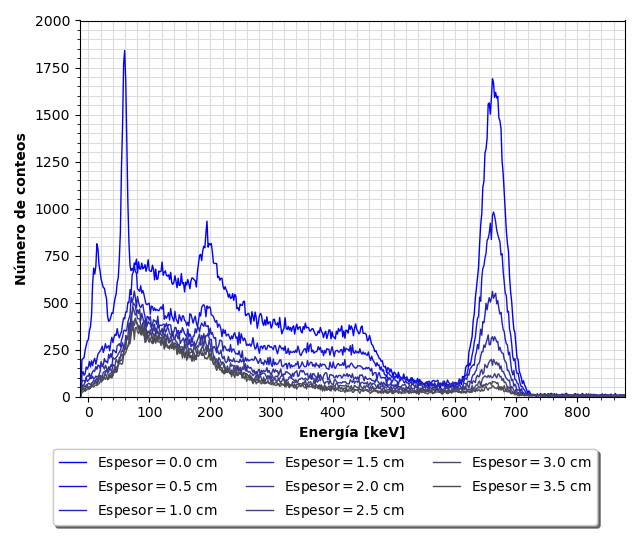

In [7]:
# Gráfica del espectro γ del plomo
%matplotlib widget

slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=3.5,
    step=0.5,
    description='Espesor:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

display(slider)

curves = []
fig, ax = plt.subplots(figsize=(6.4, 5.6))
for N, color, espesor in zip(conteos['Pb'], colors_Pb, x):
    lbl = f'Espesor$ = {espesor:.1f}$ cm'
    curves += ax.plot(E[:-1], N[:-1], lw=1, c=color, label=lbl)

ax.set_xlim([E[0], E[-2]])
ax.set_ylim([0, 2000])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel('Energía [keV]', fontweight='bold')
ax.set_ylabel('Número de conteos', fontweight='bold')

leg = ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.45, -0.36),
    ncols=3,
    fancybox=True,
    shadow=True,
)
fig.add_artist(leg)
plt.tight_layout()
plt.savefig("graficas\\espectro_plomo.pdf", format="pdf", bbox_inches='tight')
plt.show()


def select_curve(change):
    selected_val = change['new']
    for i, curve in enumerate(curves):
        if i == int(selected_val * 2):
            curve.set_alpha(1)
        else:
            curve.set_alpha(0.4)
    fig.canvas.draw_idle()


slider.observe(select_curve, names='value')

FloatSlider(value=0.0, continuous_update=False, description='Espesor:', max=3.5, step=0.5)

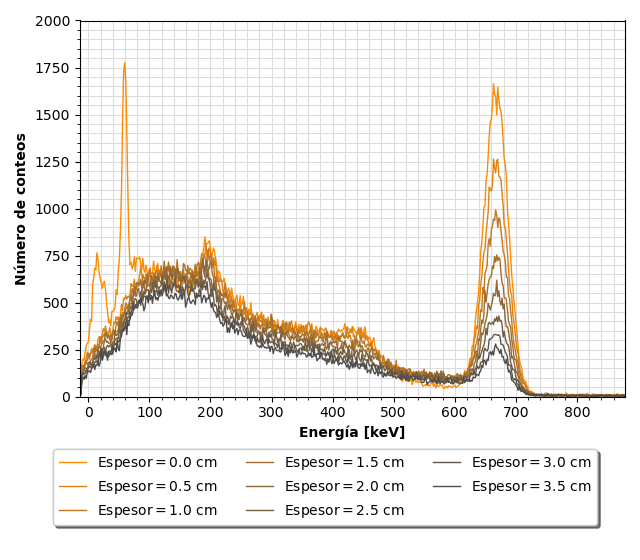

In [8]:
# Gráfica del espectro γ del acero 304
slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=3.5,
    step=0.5,
    description='Espesor:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

display(slider)

curves = []
fig, ax = plt.subplots(figsize=(6.4, 5.6))
for N, color, espesor in zip(conteos['Acero'], colors_Acero, x):
    lbl = f'Espesor$ = {espesor:.1f}$ cm'
    curves += ax.plot(E[:-1], N[:-1], lw=1, c=color, label=lbl)

ax.set_xlim([E[0], E[-2]])
ax.set_ylim([0, 2000])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel('Energía [keV]', fontweight='bold')
ax.set_ylabel('Número de conteos', fontweight='bold')

leg = ax.legend(
    loc='lower center',
    bbox_to_anchor=(0.45, -0.36),
    ncols=3,
    fancybox=True,
    shadow=True,
)
fig.add_artist(leg)
plt.tight_layout()
plt.savefig("graficas\\espectro_acero.pdf", format="pdf", bbox_inches='tight')
plt.show()


def select_curve(change):
    selected_val = change['new']
    for i, curve in enumerate(curves):
        if i == int(selected_val * 2):
            curve.set_alpha(1)
        else:
            curve.set_alpha(0.4)
    fig.canvas.draw_idle()


slider.observe(select_curve, names='value')

# [Coeficiente de atenuación lineal para radiación gamma](https://en.wikipedia.org/wiki/Beer%E2%80%93Lambert_law)

El coeficiente de atenuación lineal para la radiación incidente $\mu$ de un material describe cuál es la probabilidad de que la radiación incidente sea absorbida por unidad de longitud del material. La relación de este coeficiente con la intensidad de la intensidad es

$$
\boxed{I(x) = I_0 e^{-\mu x},}
$$

donde $I$ es la intensidad incidente, $I_0$ es la intensidad incidente inicial (sin material de por medio) y $x$ la distancia que recorre la radiación dentro del material. En el caso de que el material tenga forma de ortoedro y la radiación incidente sea perpendicular a una de las caras del material, entonces, esta $x$ representa el grosor del material respecto al eje de incidencia.

## Transformación para la regresión por OLS
Para determinar este factor se va a realizar una regresión lineal simple de la forma $Y = aX + b$, donde

$$
\begin{cases}
    X = \ln x \\
    Y = I
\end{cases}
\implies
\begin{cases}
    \mu = - a \\
    I_0 = e^b
\end{cases}.
$$

Para determinar el error de $I_0$ se usó la propagación de errores

$$
\Delta I_0 = \left\vert \frac{\partial I_0}{\partial b} \right\vert \Delta b = \left\vert \frac{\partial e^b}{\partial b} \right\vert \Delta b  = \vert I_0 \vert \Delta b .
$$


In [9]:
# Ajustes exponenciales de la intensidad
ajuste_Pb = linregress(x, np.log(intensidades['Pb']))
ajuste_Acero = linregress(x, np.log(intensidades['Acero']))

mu = {
    'Pb': {
        'valor': -ajuste_Pb.slope,
        'error': ajuste_Pb.stderr
    },
    'Acero': {
        'valor': -ajuste_Acero.slope,
        'error': ajuste_Acero.stderr
    }
}

I_0 = {
    'Pb': {
        'valor': np.exp(ajuste_Pb.intercept),
        'error': ajuste_Pb.intercept_stderr * np.exp(ajuste_Pb.intercept)
    },
    'Acero': {
        'valor': np.exp(ajuste_Acero.intercept),
        'error': ajuste_Acero.intercept_stderr * np.exp(ajuste_Acero.intercept)
    }
}

In [10]:
intensidades['Pb']

array([43335, 24479, 14326,  8180,  4441,  2883,  1743,  1227],
      dtype=uint32)

In [11]:
# Variables de las gráficas
X = np.linspace(-0.2, 3.7, 50)
Y1 = I_0['Pb']['valor'] * np.exp(ajuste_Pb.slope * X)
Y2 = I_0['Acero']['valor'] * np.exp(ajuste_Acero.slope * X)

regr1_label = f'$I = ({I_0['Pb']['valor']/10000:.1f} \\pm {I_0['Pb']['error']/10000:.1f}) \\times' + '10^4 \\; e^{(' + f'-{mu['Pb']['valor']:.2f} \\pm {mu['Pb']['error']:.2f}' + ') x}$'
regr2_label = f'$I = ({I_0['Acero']['valor']/10000:.2f} \\pm {I_0['Acero']['error']/10000:.2f}) \\times' + '10^4 \\; e^{(' + f'-{mu['Acero']['valor']:.3f} \\pm {mu['Acero']['error']:.3f}' + ') x}$'

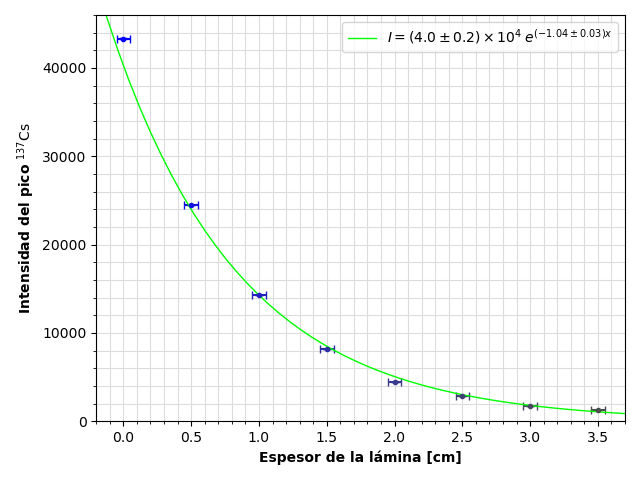

In [12]:
# Grafica intensidad contra espesor para el plomo
fig, ax = plt.subplots()
for espesor, intensidad, marker_color in zip(x, intensidades['Pb'].astype(float), colors_Pb):
    ax.errorbar(
        espesor,
        intensidad,
        yerr=10,
        xerr=0.05,
        capsize=3,
        color=marker_color,
        elinewidth=1.5,
        fmt='.'
    )

ax.plot(
    X,
    Y1,
    c='lime',
    lw=1,
    label=regr1_label
)

ax.set_xlim([-0.2, 3.7])
ax.set_ylim([0, 46000])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel('Espesor de la lámina [cm]', fontweight='bold')
ax.set_ylabel('Intensidad del pico $^{137}\\mathrm{Cs}$', fontweight='bold')
ax.legend()
plt.tight_layout()

plt.show()

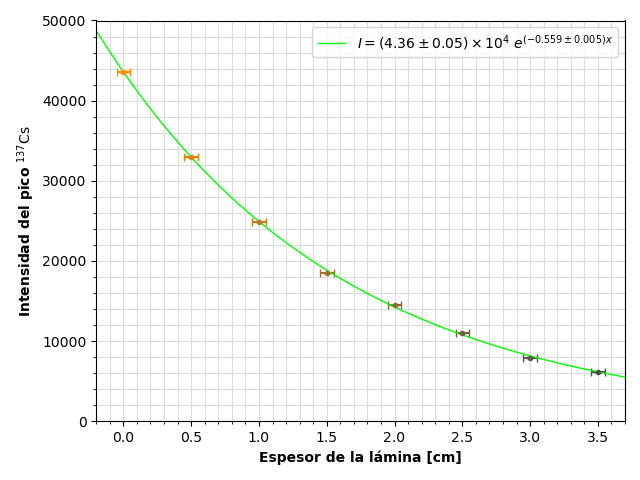

In [13]:
# Grafica intensidad contra espesor para el acero
fig, ax = plt.subplots()
for espesor, intensidad, marker_color in zip(x, intensidades['Acero'].astype(float), colors_Acero):
    ax.errorbar(
        espesor,
        intensidad,
        yerr=10,
        xerr=0.05,
        capsize=3,
        color=marker_color,
        elinewidth=1.5,
        fmt='.'
    )

ax.plot(
    X,
    Y2,
    c='lime',
    lw=1,
    label=regr2_label
)

ax.set_xlim([-0.2, 3.7])
ax.set_ylim([0, 50000])
ax.minorticks_on()
ax.grid(True, which='both', zorder=0, color='gainsboro')
ax.set_xlabel('Espesor de la lámina [cm]', fontweight='bold')
ax.set_ylabel('Intensidad del pico $^{137}\\mathrm{Cs}$', fontweight='bold')
ax.legend()
plt.tight_layout()

plt.show()

In [14]:
# Reporte de valores relevantes del ajuste
K = ['Pb', 'Acero']
ajustes = [ajuste_Pb, ajuste_Acero]

for key, ajuste in zip(K, ajustes):
    print(f'μ^({key}) = ({mu[key]['valor']:.3f} ± {mu[key]['error']:.3f}) cm⁻¹')
    print(f'I_0^({key}) = {I_0[key]['valor']:.2e} ± {I_0[key]['error']:.0e}')
    print(f'R² = {ajuste.rvalue ** 2:.4f}\n')

μ^(Pb) = (1.038 ± 0.027) cm⁻¹
I_0^(Pb) = 4.03e+04 ± 2e+03
R² = 0.9959

μ^(Acero) = (0.559 ± 0.005) cm⁻¹
I_0^(Acero) = 4.36e+04 ± 5e+02
R² = 0.9995



In [15]:
# FWHM del pico de Cesio-137
arr = conteos['Pb'][0][256:-1]
HM = arr.max() / 2
diff_abs = np.abs(arr - HM)
idx_1 = np.argmin(diff_abs) + 256  # derecha

arr = conteos['Pb'][0][256:idx_1]
diff_abs = np.abs(arr - HM)
idx_2 = np.argmin(diff_abs) + 256  # izquierda

error_canales = (E[-1] - E[0]) / 512
error_pico = np.sqrt(error_canales ** 2 + (E[idx_1] - E[idx_2]) ** 2)
print(f'FWHM del pico de Cesio-137 (661.66 ± 0.01) keV: {error_pico:.1f} keV.')

FWHM del pico de Cesio-137 (661.66 ± 0.01) keV: 45.5 keV.


## Resultados del ajuste

Para el pico de radiación $\gamma$ del Cesio-137 con una energía de $(0.66 \pm 0.02)$ $\mathrm{MeV}$ se obtuvieron los siguientes valores:

| Material | $\mu \; [\mathrm{cm}^{-1}]$ | $\Delta \mu \; [\mathrm{cm}^{-1}]$ | $I_0$              | $\Delta I_0$       | $R^2$    |
| -------- | --------------------------- | ---------------------------------- | ------------------ | ------------------ | -------- |
| Plomo    | $1.04$                      | $0.03$                             | $4.0 \times 10^4$  | $0.2 \times 10^4$  | $0.9959$ |
| Acero    | $0.560$                     | $0.005$                            | $4.36 \times 10^4$ | $0.05 \times 10^4$ | $0.9995$ |

---

## [Coeficiente de atenuación másico](https://en.wikipedia.org/wiki/Mass_attenuation_coefficient)

Una vez determinados los coeficientes de atenuación lineales con estos valores se pueden determinar los coeficientes de atenuación másicos para cada material de la forma

$$
\boxed{\frac{\mu}{\rho_m},}
$$

donde $\rho_m$ es la densidad del material. Tomando los valores de $\mu$ ya encontrados experimentalmente y los valores de referencia
-  [Densidad del plomo:](https://web.archive.org/web/20200726182045/https://www.ila-lead.org/UserFiles/File/factbook/leadTheFacts.pdf) $11.3$ $\mathrm{g \; cm}^{-3}$.
-  [Densidad del acero inoxidable 304:](https://www.amardeepsteel.com/blog/density-of-stainless-steel-304.html) $7.93$ $\mathrm{g \; cm}^{-3}$.
-  [Coeficiente de atenuación másico del plomo a $0.6$ $MeV$:](https://physics.nist.gov/PhysRefData/XrayMassCoef/ElemTab/z82.html) $124.8$ $\mathrm{kg}^{-1} \; \mathrm{cm}^2$

### Coeficiente de atenuación másico del acero inoxidable 304 (SAE 304)

Dado que las láminas del acero son un material compuesto, vamos a suponer que en el proceso de frabricación de este material no emergen efectos químicos que afecten las propiedades de atenuación de los elementos involucrados y que además las láminas son homogéneas. Con esto en cuenta se tiene la siguiente tabla (ASTM A240/A240M)

| Elemento      | [Composición](https://www.theworldmaterial.com/type-304-grade-stainless-steel/) | [$\mu_i / \rho_i$ a $0.6$ $\mathrm{MeV} \; [\mathrm{kg}^{-1} \; \mathrm{cm}^2]$](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab3.html) |
| ------------- | ----------- | ------------------------------------------------------------------------------ |
| $\mathrm{Fe}$ | $69.605 \%$ | $77.04$                                                                        |
| $\mathrm{Cr}$ | $18.500 \%$ | $75.98$                                                                        |
| $\mathrm{Ni}$ | $9.000 \%$  | $79.44$                                                                        |
| $\mathrm{Mn}$ | $2.000 \%$  | $75.09$                                                                        |
| $\mathrm{Si}$ | $0.750 \%$  | $80.77$                                                                        |
| $\mathrm{C}$  | $0.070 \%$  | $80.58$                                                                        |
| $\mathrm{P}$  | $0.045 \%$  | $78.54$                                                                        |
| $\mathrm{S}$  | $0.030 \%$  | $81.02$                                                                        |

In [16]:
# Valores de referencia
mu_rho_Pb_teorico = 1.248E-01 * 1000  # [cm²/kg]
composicion_acero = np.array([69.605, 18.5, 9, 2, 0.75, 0.07, 0.045, 0.03],
                             dtype=np.float64) / 100
mu_elementos_acero = np.array(
    [77.04, 75.98, 79.44, 75.09, 80.77, 80.58, 78.54, 81.02], dtype=np.float64
)  # [cm²/kg]
mu_rho_Acero_teorico = np.sum(mu_elementos_acero * composicion_acero)

rho_Pb = 11.3 / 1000  # [kg/cm³]
rho_Acero = 7.93 / 1000  # [kg/cm³]

In [17]:
# Cálculo de los coeficientes de atenuación másicos experimentales
mu_rho_Pb_experimental = mu['Pb']['valor'] / rho_Pb
Delta_mu_rho_Pb_experimental = mu['Pb']['error'] / rho_Pb

mu_rho_Acero_experimental = mu['Acero']['valor'] / rho_Acero
Delta_mu_rho_Acero_experimental = mu['Acero']['error'] / rho_Acero

In [18]:
# Reporte de los valores
print('============================== Coeficientes de atenuación másicos ==============================')
print(f'· Plomo: Coeficiente de atenuación másico ({mu_rho_Pb_experimental:4.0f} ± {Delta_mu_rho_Pb_experimental:3.0f}) kg⁻¹ cm²,     Error porcentual = {abs(mu_rho_Pb_experimental - mu_rho_Pb_teorico) / mu_rho_Pb_teorico:6.2%}')
print(f'· Acero: Coeficiente de atenuación másico ({mu_rho_Acero_experimental:4.1f} ± {Delta_mu_rho_Acero_experimental:3.1f}) kg⁻¹ cm²,     Error porcentual = {abs(mu_rho_Acero_experimental - mu_rho_Acero_teorico) / mu_rho_Acero_teorico:6.2%}')

============================== Coeficientes de atenuación másicos ==============================
· Plomo: Coeficiente de atenuación másico (  92 ±   2) kg⁻¹ cm²,     Error porcentual = 26.42%
· Acero: Coeficiente de atenuación másico (70.5 ± 0.7) kg⁻¹ cm²,     Error porcentual =  8.52%
